# **Week 5 - Pet Re-Identification (Pet_ReID)**

## EAI 6010 / Spring B / 2025

## Date: 06/18/25

## Lueji Phaphety

# **Import Required Libraries**
This cell imports libraries for handling datasets, images, and transformations.

In [31]:
# This section handles installing required packages and importing libraries.

!pip install -q gradio torch torchvision

import os
import torch
import random
import numpy as np
import gradio as gr
import torch.nn as nn
from PIL import Image
from pathlib import Path
import torch.optim as optim
from torch.optim import Adam
from fastai.vision.all import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision.models as models
from collections import defaultdict
from torch.utils.data import Dataset
from torchvision import transforms as T
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision.utils import save_image
!pip install -qq torch torchvision fastai
from fastai.data.external import untar_data, URLs
from torch.utils.data import Dataset, random_split
from sklearn.metrics import accuracy_score, roc_auc_score

#  **Mount Google Drive**
Mount Google Drive to access project files stored remotely.

In [32]:
#from google.colab import drive
#drive.mount('/content/drive')

In [33]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# ⚙️ **Install fastbook**
Ensure `fastbook` is installed and setup for using FastAI utilities.

In [34]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

# **Create Project Directory**
Check if model directory exists in Google Drive; create it if not.

In [35]:
# Create directory structure with subfolders
!mkdir -p Pet_ReID_Space/{models,notebooks,scripts,data,images,utils}

# Create placeholder files
!touch Pet_ReID_Space/app.py
!touch Pet_ReID_Space/scripts/train.py
!touch Pet_ReID_Space/scripts/inference.py
!touch Pet_ReID_Space/models/siamese_model.pth
!touch Pet_ReID_Space/utils/helpers.py
!touch Pet_ReID_Space/requirements.txt
!touch Pet_ReID_Space/README.md

# **Define Model Path**
Set the path to the trained Siamese model.

In [36]:
model_path = '/content/drive/MyDrive/Pet_ReID_Space/siamese_model.pth'

BASE_DIR = '/content/drive/MyDrive/Pet_ReID_Space'
model_path = os.path.join(BASE_DIR, 'siamese_model.pth')

In [37]:
# Pet Re-ID (Week 1): Data Preparation and visulization using fastai
#!pip freeze | grep torch  # or any other package name
#!pip install -U fastai
#from fastai.vision.all import *
#import random
#from pathlib import Path
#from collections import defaultdict

# Download & Inspect Oxford Pets Dataset


What it does:

Downloads and extracts the Oxford Pets dataset using fastai.

Points to the images folder and prints basic checks: folder path, existence, and the first few image files.

In [38]:
from fastai.vision.all import *
from collections import defaultdict

# Step 1: Load and show images
path = untar_data(URLs.PETS)
images_folder = path / 'images'

print(images_folder)
print(images_folder.exists())
print(list(images_folder.iterdir())[:5])  # Show first 5 files

/root/.fastai/data/oxford-iiit-pet/images
True
[Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_106.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_10.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_186.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_146.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_50.jpg')]


In [39]:
from collections import defaultdict
# Create pet_dict
pet_dict = defaultdict(list)
for img_path in images_folder.iterdir():
    if img_path.suffix == '.jpg':
        pet_name = "_".join(img_path.stem.split("_")[:-1])
        pet_dict[pet_name].append(img_path)

In [40]:
print(f"Total pets in pet_dict: {len(pet_dict)}")
for pid, imgs in list(pet_dict.items())[:5]:
    print(f"Pet ID: {pid}, Number of images: {len(imgs)}")

Total pets in pet_dict: 37
Pet ID: chihuahua, Number of images: 200
Pet ID: english_cocker_spaniel, Number of images: 200
Pet ID: Bengal, Number of images: 200
Pet ID: leonberger, Number of images: 200
Pet ID: wheaten_terrier, Number of images: 200


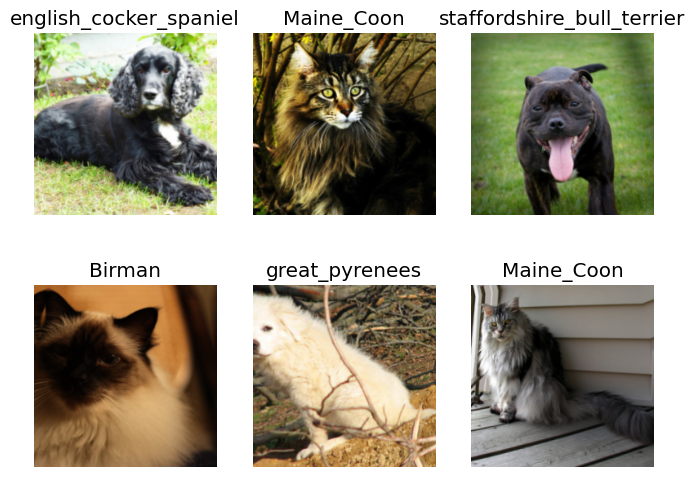

In [41]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)
files = get_image_files(path/'images')

dls = ImageDataLoaders.from_name_re(
    path,
    files,
    r'^(.*)_\d+.jpg$',   # regex pattern to extract labels from filenames
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)

dls.show_batch(max_n=6, figsize=(8,6))

In [42]:
# Function to extract pet ID from filename
def get_pet_id(filename): return filename.stem.split("_")[0]

# Function to build pet_dict
def build_pet_dict_from_filenames(images_folder):
    pet_dict = defaultdict(list)
    for img_path in images_folder.iterdir():
        if img_path.suffix.lower() in ['.png', '.jpg', '.jpeg']:
            name = img_path.stem
            pet_id = '_'.join(name.split('_')[:-1])
            pet_dict[pet_id].append(str(img_path))
    return dict(pet_dict)

Create Positive and Negative Pairs for Siamese Training

What it does:

Generates image pairs for training the Siamese network.

Positive pairs (label=1): Two different images of the same pet.

Negative pairs (label=0): Images from two different pets.

Returns a list of tuples: (img_path1, img_path2, label).

In [43]:
# Create positive and negative pairs
def create_pairs(pet_dict, num_pairs=100):
    pairs = []
    pet_ids = list(pet_dict.keys())

    for _ in range(num_pairs // 2):
        pet_id = random.choice(pet_ids)
        imgs = random.sample(pet_dict[pet_id], 2)
        pairs.append((imgs[0], imgs[1], 1))

        pet_id1, pet_id2 = random.sample(pet_ids, 2)
        img1 = random.choice(pet_dict[pet_id1])
        img2 = random.choice(pet_dict[pet_id2])
        pairs.append((img1, img2, 0))

    return pairs

Create Pairs and Apply Transforms

What it does:

Creates pairs of images for training (you’ll need a create_pairs() function here).

Applies basic transforms: resize to 128×128 and convert to tensor.

In [44]:
# Build pet_dict and create pairs
pet_dict = build_pet_dict_from_filenames(images_folder)
pairs = create_pairs(pet_dict, num_pairs=100)

# Define transform
transform = T.Compose([T.Resize((128, 128)), T.ToTensor()])

Define a Custom Siamese DataSet

In [45]:
# Defines a custom dataset class for paried images and labels used in Siamese networks.

class SiamesePetDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs                        # List of (img1, imag2. label)
        self.transform = transform or T.ToTensor()

    def __len__(self):
        return len(self.pairs)                  # Total samples

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        return (img1, img2), torch.tensor(label, dtype=torch.float)

# Create dataset
transform = T.Compose([T.Resize((128, 128)), T.ToTensor()])
siamese_ds = SiamesePetDataset(pairs, transform=transform)

**Dataset Visualization**

What it does:

Displays 3 random image pairs from the dataset.

Shows both images side by side

Prints their label as “Same” or “Different”

Helps verify that image loading and pairing are working correctly

Label: Same


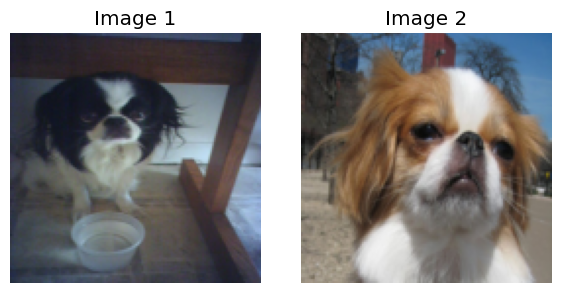

Label: Different


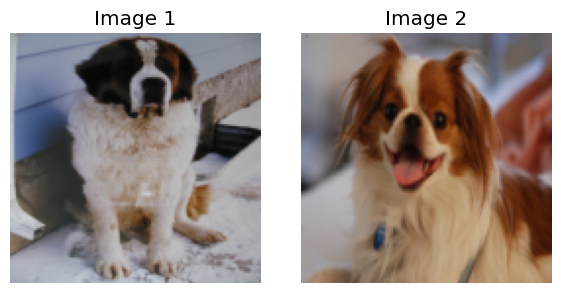

Label: Same


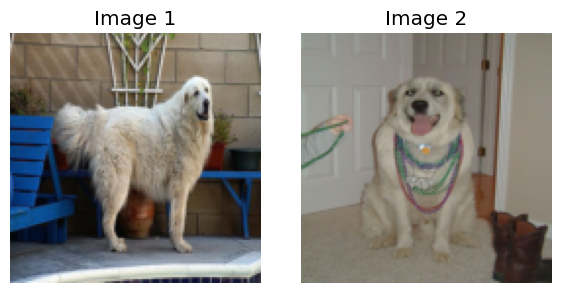

In [46]:
# Visualize image pairs

import matplotlib.pyplot as plt

for i in range(3):
    (im1, im2), label = siamese_ds[i]
    print(f"Label: {'Same' if label == 1.0 else 'Different'}")

    _, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(im1.permute(1, 2, 0))
    axs[0].set_title('Image 1')
    axs[0].axis('off')

    axs[1].imshow(im2.permute(1, 2, 0))
    axs[1].set_title('Image 2')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# **Build Model and Train**

EmbeddingNet (ResNet18 encoder), SiameseNet

Implement contrastive loss

Build training loop with optimizer and device handling

Log training losses


Dstaset Split: Train and Validation

In [47]:
# Split into training and validation sets
train_size = int(0.8 * len(siamese_ds))
valid_size = len(siamese_ds) - train_size
train_ds, valid_ds = random_split(siamese_ds, [train_size, valid_size])

print(f"Train size: {len(train_ds)}, Validation size: {len(valid_ds)}")

Train size: 80, Validation size: 20


# **Model Architecture (Siamese Network)**
Model plus Loss

In [48]:
# Encoder using pretrained ResNet-18
class EmbeddingNet(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        m = resnet18(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Linear(512, out_dim)

    def forward(self, x):
        x = self.backbone(x)              # (B, 512, 1, 1)
        x = x.view(x.size(0), -1)         # Flatten to (B, 512)
        x = self.fc(x)                    # (B, out_dim)
        return F.normalize(x, p=2, dim=1) # L2 normalize (optional but common)

Siamese network returns distance

In [49]:
# Siamese network computes distance between embeddings
class SiameseNet(nn.Module):
    def __init__(self, embedding_dim=256):
        super().__init__()
        self.encoder = EmbeddingNet(embedding_dim)

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        return F.pairwise_distance(z1, z2)

Contrastive Loss Function

Create DataLoader

In [50]:
# Create dataleader
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

Training Loop

In [51]:
# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss, and optimizer
model = SiameseNet().to(device)
criterion = nn.HingeEmbeddingLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# Train loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for (img1, img2), labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(img1, img2), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/10, Loss: {total_loss/len(train_loader):.4f}')

Epoch 1/10, Loss: 0.8217
Epoch 2/10, Loss: 0.6219
Epoch 3/10, Loss: 0.5624
Epoch 4/10, Loss: 0.5411
Epoch 5/10, Loss: 0.5350
Epoch 6/10, Loss: 0.5330
Epoch 7/10, Loss: 0.5307
Epoch 8/10, Loss: 0.5297
Epoch 9/10, Loss: 0.5284
Epoch 10/10, Loss: 0.5277


# **Validation And Embedding Visualization with t-SNE**

Implement validation loop

Generate embeddings from validation set

Apply t-SNE to visualize separation of pet identities

Display scatter plot of embeddings colored by label

Validation Loop


 Visual Inspection of Siamese Pairs

 Displays image pairs from the validation set with similarity labels (Same or Different) to qualitatively verify data and model logic.

Label: Same


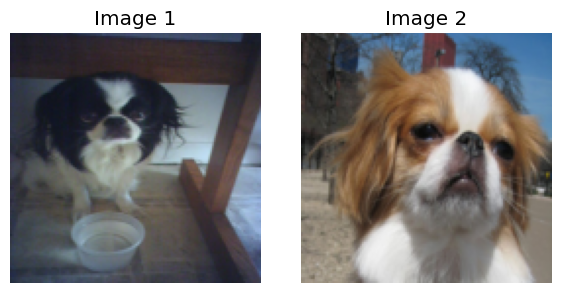

Label: Different


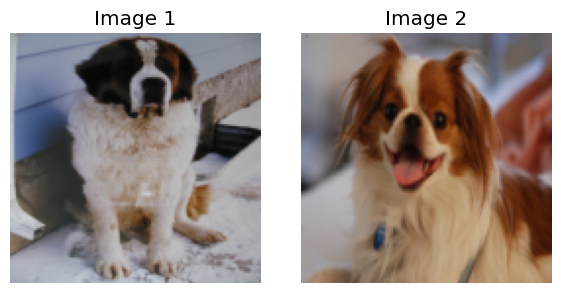

Label: Same


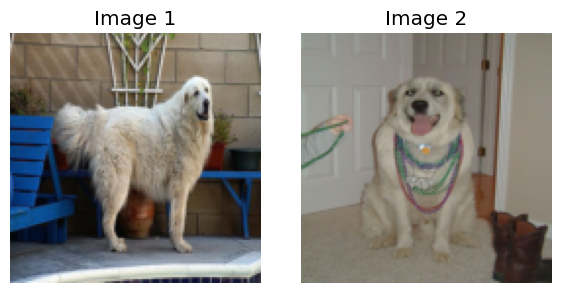

In [52]:
# Visualization of Results

import matplotlib.pyplot as plt

for i in range(3):
    (im1, im2), label = siamese_ds[i]
    print(f"Label: {'Same' if label == 1.0 else 'Different'}")

    _, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(im1.permute(1, 2, 0))
    axs[0].set_title('Image 1')
    axs[0].axis('off')

    axs[1].imshow(im2.permute(1, 2, 0))
    axs[1].set_title('Image 2')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

T-SNE Plot of Validation Embeddings

Extracts embeddings of 200 validation images and visualizes them in 2D using t-SNE to assess clustering by pet identity.

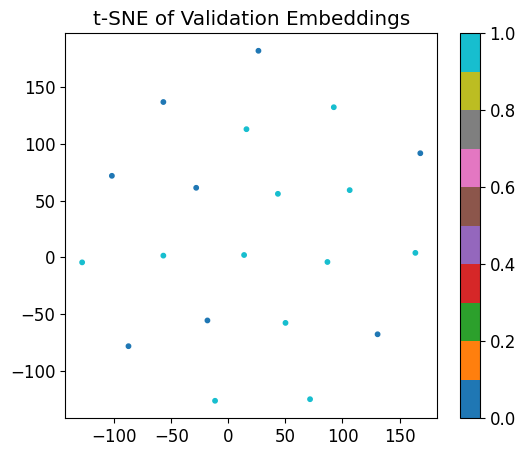

In [53]:
from sklearn.manifold import TSNE
import numpy as np

model.eval()
embs, labs = [], []

with torch.no_grad():
    for i in range(min(200, len(valid_ds))):
        (x1, _), y = valid_ds[i]
        embs.append(model.encoder(x1.unsqueeze(0).to(device)).cpu())
        labs.append(int(y.item()))

# Convert to numpy and apply t-SNE
emb_array = np.stack([e.squeeze().numpy() for e in embs])
adjusted_perplexity = min(30, len(emb_array) - 1)

tsne = TSNE(n_components=2, perplexity=adjusted_perplexity, init="pca", random_state=42)
points = tsne.fit_transform(emb_array)

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(points[:, 0], points[:, 1], c=labs, cmap='tab10', s=10)
plt.colorbar()
plt.title("t-SNE of Validation Embeddings")
plt.show()

Custom Pair Prediction

In [54]:
from torchvision.utils import save_image
import torchvision.transforms as T
from PIL import Image

# Define transform and prediction function
pair_tf = T.Compose([T.Resize((128,128)), T.ToTensor()])

def predict_pair(img_path1, img_path2, thresh=0.5):
    model.eval()
    img1 = pair_tf(Image.open(img_path1).convert('RGB')).unsqueeze(0).to(device)
    img2 = pair_tf(Image.open(img_path2).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        dist = model(img1, img2).item()
    verdict = "SAME pet" if dist < thresh else "DIFFERENT pets"
    print(f"Distance = {dist:.3f}  ➜  {verdict}")

# Select 2 images from your validation set
(img1, img2), _ = valid_ds[0]

# Save them for manual inspection and prediction
save_image(img1, 'cat1.jpg')
save_image(img2, 'cat2.jpg')

# Predict
predict_pair('cat1.jpg', 'cat2.jpg')

Distance = 0.041  ➜  SAME pet


# Gradio UI Layout
Pet Re-Identification App (Gradio Interface)

This app allows users to:
Compare two pet images to determine if they are the same pet.

Search a lost pet image against a database of known pets using embedding similarity.

Pet_ReID: Image Similarity App (Siamese Network + Gradio)

In [55]:
# Install
!pip install gradio torch torchvision --quiet

# **Launch the App**

**Compare** Two Pet Images (Siamese Distance)

In [56]:
def predict_pair_gr(img1_path, img2_path):
    with torch.no_grad():
        d = model(preprocess(img1_path), preprocess(img2_path)).item()
    return f"Similarity Distance: {d:.4f} (Lower = More Similar)"

**Search Gallery for Similar Pets**

In [57]:
import glob

def search_similar_gr(query_img_path, top_k=3):
    gallery = glob.glob(f"{base_path}/gallery/*.jpg")
    query = preprocess(query_img_path)

    with torch.no_grad():
        q_embed = model.encoder(query)
        results = [
            (F.pairwise_distance(q_embed, model.encoder(preprocess(p))).item(), p)
            for p in gallery
        ]

    return [p for _, p in sorted(results)[:top_k]]

Gradio App with Tab

In [58]:
with gr.Blocks() as demo:
    with gr.Tab("🔍 Compare Two Pets"):
        gr.Interface(
            fn=predict_pair_gr,
            inputs=[gr.Image(type="filepath", label="Pet Image 1"), gr.Image(type="filepath", label="Pet Image 2")],
            outputs=gr.Textbox(label="Similarity Score"),
            live=False,
        ).render()

    with gr.Tab("📂 Search Lost Pet"):
        gr.Interface(
            fn=search_similar_gr,
            inputs=gr.Image(type="filepath", label="Upload a Photo of Lost Pet"),
            outputs=gr.Gallery(label="Top Matches")
        ).render()

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://64e8b636dd162c294d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [59]:
torch.save(model.state_dict(), 'siamese_model.pth')